### This notebook calculates the predicted and observed $C^{g g}_{l}$ from *CCL* and *Healpy* (Planck map) respectively, and compares the values.

In [1]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt

import pyccl as ccl
import pymaster as nmt

Binning function from Sukhdeep

In [2]:
import itertools 

def bin_mat(r=[],mat=[],r_bins=[]):#works for cov and skewness
    bin_center=0.5*(r_bins[1:]+r_bins[:-1])
    n_bins=len(bin_center)
    ndim=len(mat.shape)
    mat_int=np.zeros([n_bins]*ndim,dtype='float64')
    norm_int=np.zeros([n_bins]*ndim,dtype='float64')
    bin_idx=np.digitize(r,r_bins)-1
    r2=np.sort(np.unique(np.append(r,r_bins))) #this takes care of problems around bin edges
    dr=np.gradient(r2)
    r2_idx=[i for i in np.arange(len(r2)) if r2[i] in r]
    dr=dr[r2_idx]
    r_dr=r*dr

    ls=['i','j','k','l']
    s1=ls[0]
    s2=ls[0]
    r_dr_m=r_dr
    for i in np.arange(ndim-1):
        s1=s2+','+ls[i+1]
        s2+=ls[i+1]
        r_dr_m=np.einsum(s1+'->'+s2,r_dr_m,r_dr)#works ok for 2-d case

    mat_r_dr=mat*r_dr_m
    for indxs in itertools.product(np.arange(min(bin_idx),n_bins),repeat=ndim):
        x={}#np.zeros_like(mat_r_dr,dtype='bool')
        norm_ijk=1
        mat_t=[]
        for nd in np.arange(ndim):
            slc = [slice(None)] * (ndim)
            #x[nd]=bin_idx==indxs[nd]
            slc[nd]=bin_idx==indxs[nd]
            if nd==0:
                mat_t=mat_r_dr[slc]
            else:
                mat_t=mat_t[slc]
            norm_ijk*=np.sum(r_dr[slc[nd]])
        if norm_ijk==0:
            continue
        mat_int[indxs]=np.sum(mat_t)/norm_ijk
        norm_int[indxs]=norm_ijk
    return bin_center,mat_int

### $C^{g g}_{l}$ from theory (CCL)

In [3]:
#define cosmology
cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96)

In [4]:
#params
fs = 18
lmin = 100; lmax = 1500
ell = np.arange(0, lmax, 1)

Define galaxy clustering 

In [5]:
#read in dNdz
dNdzddeg2 = pd.read_csv("dNdz", sep=" ")
dNdzddeg2

,z,dNdzddeg2
0,0.65,309
1,0.75,2269
2,0.85,1923
3,0.95,2094
4,1.05,1441
5,1.15,1353
6,1.25,1337
7,1.35,523
8,1.45,466
9,1.55,329


Text(0.5, 1.0, 'FDR dNdz')

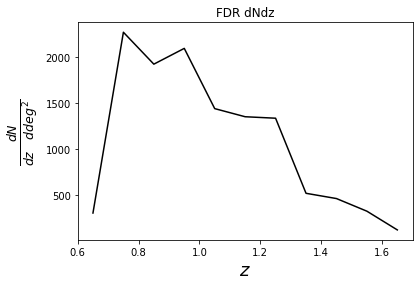

In [6]:
plt.plot(dNdzddeg2['z'], dNdzddeg2['dNdzddeg2'], 'k-')
plt.xlabel(r"$z$", fontsize = fs)
plt.ylabel(r"$\frac{dN}{dz \quad ddeg^2}$", fontsize = fs)
plt.title("FDR dNdz")

In [7]:
z = dNdzddeg2['z']
area = 14000
dNdz = dNdzddeg2['dNdzddeg2'] * area

Text(0.5, 1.0, 'dNdz from FDR')

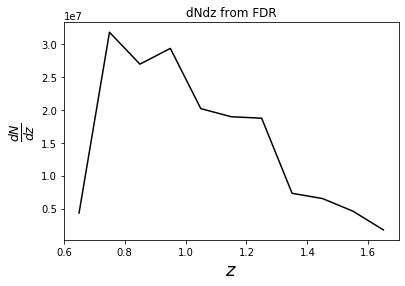

In [8]:
plt.plot(z, dNdz, 'k-')
plt.xlabel(r"$z$", fontsize = fs)
plt.ylabel(r"$\frac{dN}{dz}$", fontsize = fs)
plt.title("dNdz from FDR")

In [9]:
#set constant bias
b = 1.5*np.ones(len(z))

#Create CCL tracer object for galaxy clustering
elgl = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b))

In [10]:
#calculate theoretical Cls
cls_elg = ccl.angular_cl(cosmo, elgl, elgl, ell)

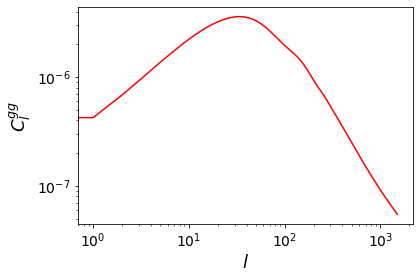

In [11]:
plt.xlabel('$l$',fontsize=fs)
plt.ylabel('$C^{g g}_{l}$',fontsize=fs)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.plot(ell, cls_elg, 'r-')
plt.show()

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


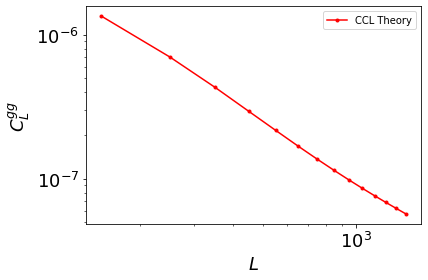

In [12]:
#binned Cls by L = 100l
ELL = np.arange(0, lmax+1, 100)
tmp = bin_mat(ell, cls_elg, ELL)

fltr = (tmp[0] > 100)
ELL_th = tmp[0][fltr]
cLgg_th = tmp[1][fltr]

plt.xlabel('$L$',fontsize=fs)
plt.ylabel('$C^{g g}_{L}$',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.yscale('log')
plt.xscale('log')
plt.plot(ELL_th, cLgg_th, 'r.-', label = 'CCL Theory')
plt.legend(loc = 'best')
plt.show()

### $C^{g g}_{l}$ from DESI Legacy Surveys DR8 and Planck 

Read in ELG catalogue

In [13]:
#load elg and random file
elgCat = np.load("elg_delta1024.npy")
randomCat = np.load("elg_ran1024.npy")

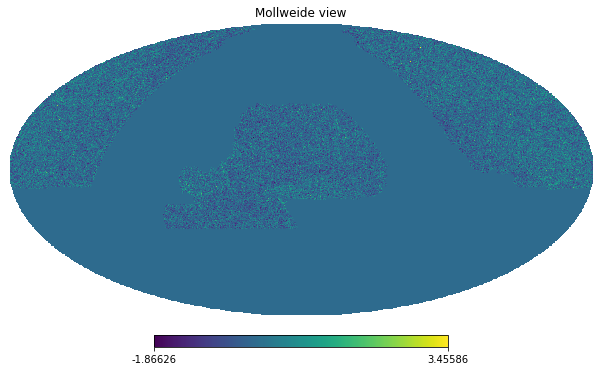

In [14]:
#view ELG catalogue
hp.mollview(elgCat)

Rotate ELG catalogue from Equatorial Coordinates to Galactic Coordinates

In [15]:
#define rotator class from Eq. Coord. to Gal. Coord
r = hp.Rotator(coord=['C','G'])

LMAX = 1500
elgCat_galactic = r.rotate_map_alms(elgCat, lmax = LMAX)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


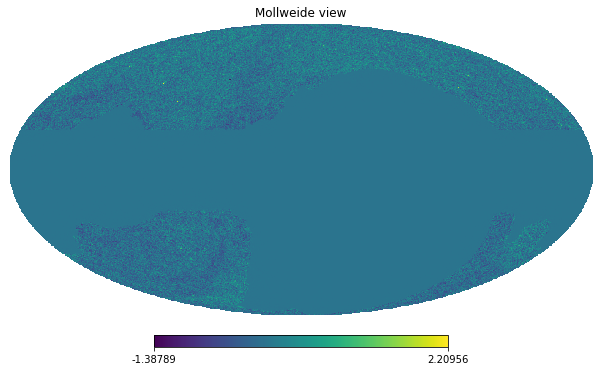

In [16]:
hp.mollview(elgCat_galactic)

In [17]:
almELG = hp.map2alm(elgCat_galactic, lmax = LMAX)

Auto-correlating in $a_{lm}$ space

In [18]:
cl_observed = hp.alm2cl(almELG, lmax = LMAX)

In [19]:
#binned Cls by L = 100l
ELL = np.arange(0, lmax+1, 100)
tmp = bin_mat(ell, cl_observed[:1500], ELL)

fltr = (tmp[0] > 100)
ELL_obs = tmp[0][fltr]
cLgg_obs = tmp[1][fltr]

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


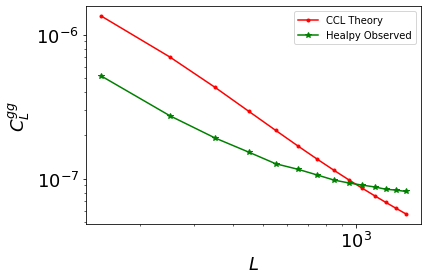

In [20]:
plt.xlabel('$L$',fontsize=fs)
plt.ylabel('$C^{g g}_{L}$',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.yscale('log')
plt.xscale('log')
plt.plot(ELL_th, cLgg_th, 'r.-', label = 'CCL Theory')
plt.plot(ELL_obs, cLgg_obs, 'g*-', label = "Healpy Observed")
plt.legend(loc = 'best')
plt.show()

Calculate sky fraction to normalize $C_l$

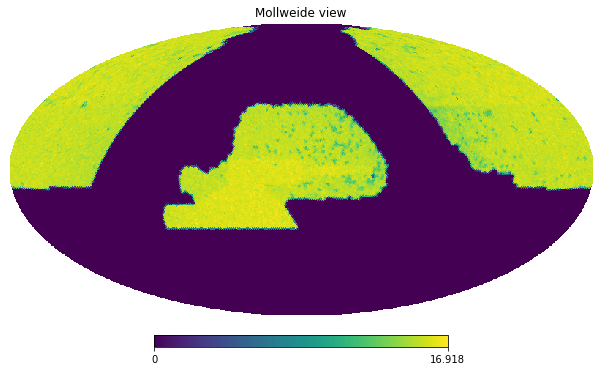

In [21]:
#checking random catalogue map at nside = 64s
hp.mollview(hp.ud_grade(randomCat, 64))

In [22]:
#Extract mask
mask_elg = hp.mask_good(hp.ud_grade(randomCat, 64), badval=0.)

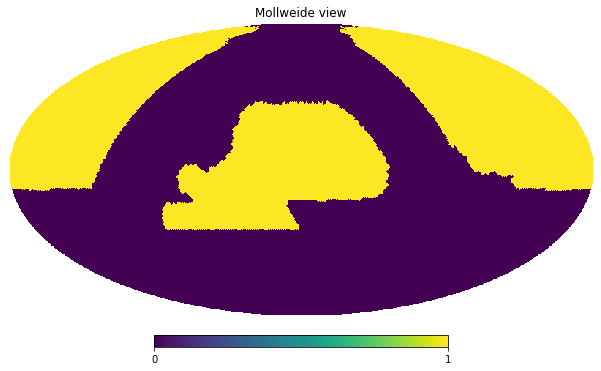

In [23]:
hp.mollview(mask_elg)

In [24]:
fsky_elg = mask_elg.sum()/mask_elg.size
fsky_elg

0.3951619466145833

Correct for sky fraction

In [25]:
#convert 2400/deg2 to #/sr; used Wolfram
shot_noise =  1/(7.88e6)

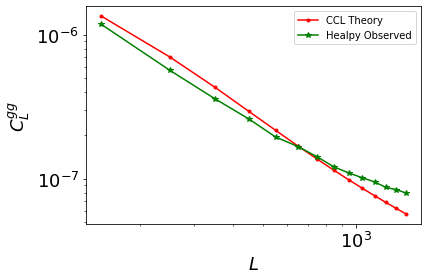

In [26]:
plt.xlabel('$L$',fontsize=fs)
plt.ylabel('$C^{g g}_{L}$',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.yscale('log')
plt.xscale('log')
plt.plot(ELL_th, cLgg_th, 'r.-', label = 'CCL Theory')
plt.plot(ELL_obs, cLgg_obs/fsky_elg - shot_noise, 'g*-', label = "Healpy Observed")
plt.legend(loc = 'best')
plt.savefig("results/cLgg.pdf")
plt.show()

In [28]:
cLgg_obs/fsky_elg - shot_noise

array([1.18024328e-06, 5.65849441e-07, 3.58868174e-07, 2.60370319e-07,
       1.94762589e-07, 1.67327792e-07, 1.41749327e-07, 1.20810004e-07,
       1.09567333e-07, 1.01545486e-07, 9.51113727e-08, 8.70568352e-08,
       8.41040776e-08, 7.96987179e-08])

Calculate RCC

In [29]:
cLgg_th

array([1.34690050e-06, 7.00283409e-07, 4.31253640e-07, 2.94031774e-07,
       2.16749791e-07, 1.68526039e-07, 1.36665876e-07, 1.14365237e-07,
       9.80668606e-08, 8.57666829e-08, 7.61771871e-08, 6.85233561e-08,
       6.22765633e-08, 5.70846342e-08])